

```
# This is formatted as code
```

# **Splitting Datasets**
*Splits the dataset into train and validation*

---





In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201


In [2]:
# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# change to project directory
%cd /content/drive/My\ Drive/AI4ALL\ Diabetic\ Retinopathy\ Research/Early\ ML\ Model/aptos2019-blindness-detection

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DwcsYZWFxUskq7gNIgNqPDzvPfHJSdsh/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection


In [3]:
x_data = np.load('x_train_CLAHE_v1.npy')
y_data = np.load('y_train2.npy')

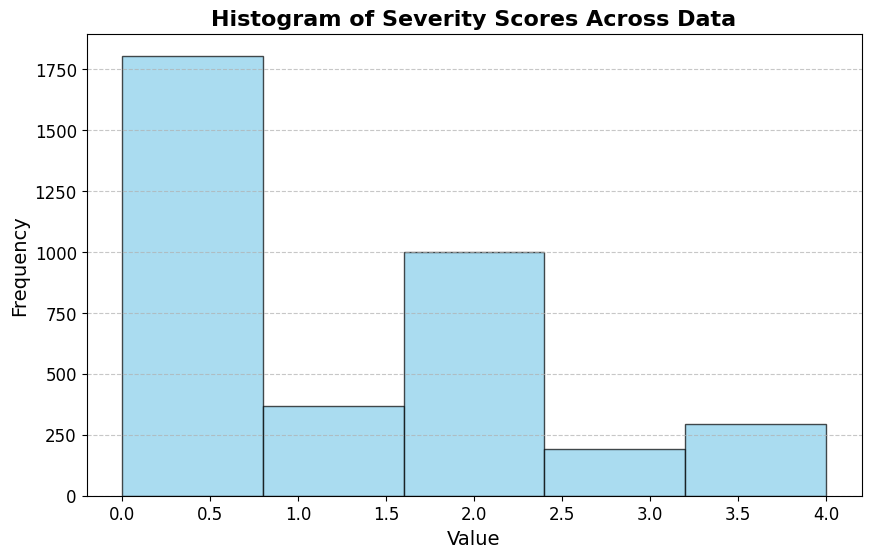

In [4]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_data, bins=5, edgecolor='black', color='skyblue', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Severity Scores Across Data', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

[1805  370  999  193  295]


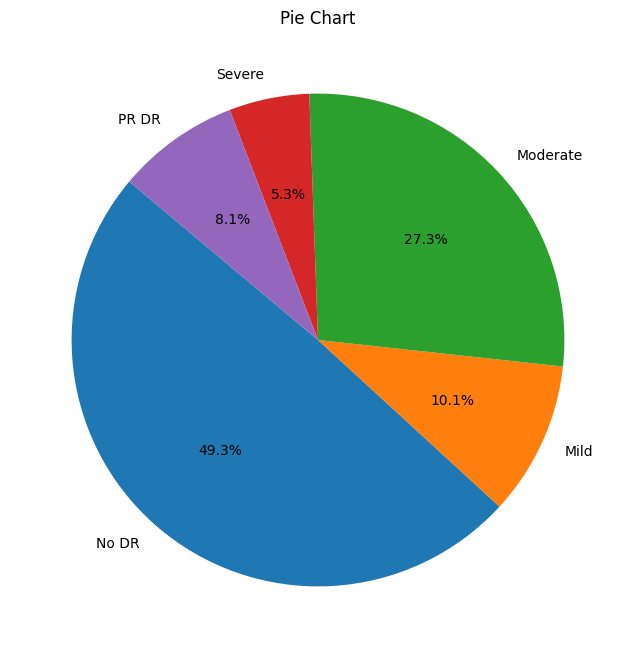

In [5]:
def count_occurrences_bincount(arr):
    # Ensure input is a NumPy array of non-negative integers
    if not np.issubdtype(arr.dtype, np.integer) or np.any(arr < 0):
        raise ValueError("Input array must be a NumPy array of non-negative integers.")

    counts = np.bincount(arr)
    return counts

# Example usage
arr = y_data
counts = count_occurrences_bincount(arr)
print(counts)

# Example numpy array with data for the pie chart
data = counts
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'PR DR']


# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: Adjust the figure size
plt.pie(data, labels=[f'{labels[i]}' for i in range(len(data))], autopct='%1.1f%%', startangle=140)

# Title for the pie chart
plt.title('Pie Chart')

# Show the plot
plt.show()

In [6]:
x_data = np.load('x_train_unfiltered.npy')
x_data_clahe = np.load('x_train_CLAHE_v2.npy')


In [7]:
for i in range(9):
  print(y_data[i])

2
4
1
0
0
4
0
2
2


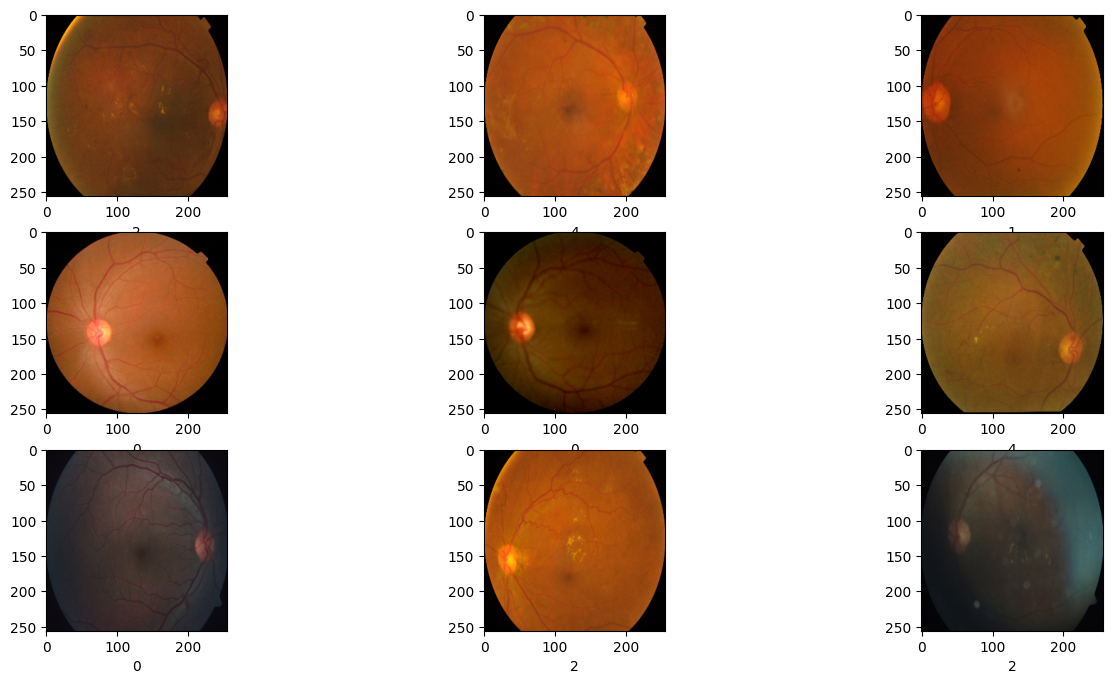

In [8]:
from numpy import random

plt.figure(figsize=(16,8))

arr = random.randint(3661, size=(9))


"""for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_data[arr[i]])
"""
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_data[i])


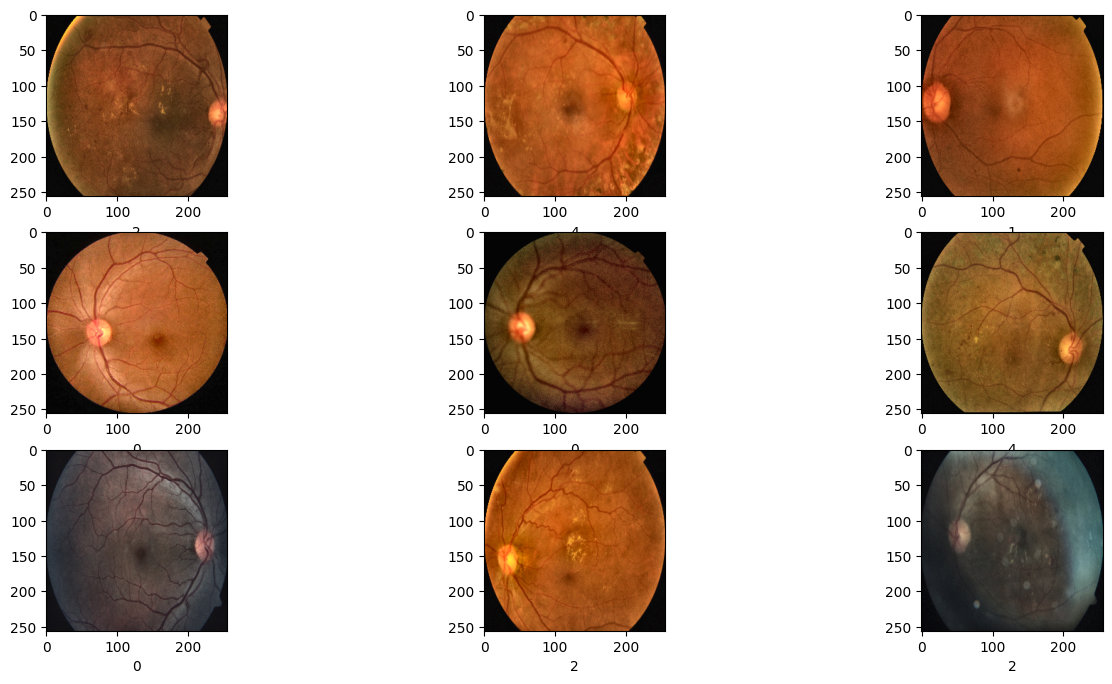

In [9]:
plt.figure(figsize=(16,8))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_data_clahe[i])

# **Data Augmentation**


---



In [10]:
len(x_data_clahe)

3662

In [11]:
train_df = pd.read_csv('train.csv')

In [12]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    return rotated

def mirror_image(image, direction):
    if direction == 0:  # 0 degrees (original)
        return image
    elif direction == 90:
        return cv2.transpose(image)[::-1, :]
    elif direction == 180:
        return cv2.flip(image, -1)
    elif direction == 270:
        return cv2.transpose(image)[:, ::-1]
    else:
        raise ValueError("Invalid mirror direction. Choose from 0, 90, 180, or 270 degrees.")

def random_saturation(image, saturation_factor_range=(0.5, 1.5)):
    # Convert image from BGR to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Generate a random saturation factor
    saturation_factor = random.uniform(*saturation_factor_range)

    # Scale the saturation channel
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_factor, 0, 255)

    # Convert back to BGR
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

def add_speckle_noise(image, mean=0, var=0.01):
    gauss = np.random.normal(mean, var**0.5, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image


def random_darkening(image, min_factor=0.7, max_factor=0.9):
    factor = np.random.uniform(min_factor, max_factor)
    darkened = np.clip(image * factor, 0, 255).astype(np.uint8)
    return darkened


def crop_around_center(image, crop_size):
    h, w = image.shape[:2]
    center_y, center_x = h // 2, w // 2
    crop_half_size = crop_size // 2

    y1 = max(center_y - crop_half_size, 0)
    y2 = min(center_y + crop_half_size, h)
    x1 = max(center_x - crop_half_size, 0)
    x2 = min(center_x + crop_half_size, w)

    # Ensure crop dimensions are within image bounds
    cropped_image = image[y1:y2, x1:x2]

    return cropped_image

def random_rotation(image, rotation_range=(-30, 30)):
    angle = random.uniform(*rotation_range)
    return rotate_image(image, angle)

In [13]:
def augmentation1(image, desired_size=256):
    im = image
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    #im = cv2.resize(im,(desired_size,)*2)
    im = cv2.transpose(image)[::-1, :]
    im = random_saturation(im)
    #res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return im

def augmentation2(image, desired_size=256):
    im = image
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    #im = cv2.resize(im,(desired_size,)*2)
    im = cv2.flip(image, -1)
    im = random_saturation(im)
    im = add_speckle_noise(im)
    #res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return im

def augmentation3(image, desired_size=256):
    im = image
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    #im = cv2.resize(im,(desired_size,)*2)
    im = cv2.transpose(image)[:, ::-1]
    im = random_saturation(im)
    im = random_darkening(im)
    #res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return im

def augmentation4(image, desired_size=256):
    im = image
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    #im = cv2.resize(im,(desired_size,)*2)
    im = cv2.transpose(image)[:, ::-1]
    im = random_saturation(im)
    im = random_darkening(im, min_factor = 0.6)
    #im = add_salt_and_pepper_noise(im)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

In [14]:
N1 = counts[3]
x_augment1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(i < 10):
    x_augment1[i, :, :, :] = augmentation4(x_data_clahe[i])
    j += 1

3662it [00:00, 9612.05it/s]


# **Indivudal Augmentations**



---



### Severity 1

In [ ]:
counts[1]

370

In [ ]:
N1 = counts[1]
severity_1_v1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 1):
    severity_1_v1[j, :, :, :] = augmentation1(x_data_clahe[i])
    j += 1

3662it [00:07, 496.09it/s]


In [ ]:
#tqdm
severity_1_v2 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 1):
    severity_1_v2[j, :, :, :] = augmentation2(x_data_clahe[i])
    j += 1

3662it [00:07, 479.32it/s]


In [ ]:
#tqdm
severity_1_v3 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 1):
    severity_1_v3[j, :, :, :] = augmentation3(x_data_clahe[i])
    j += 1

3662it [00:07, 467.37it/s]


### Severity 3

In [ ]:
counts[3]

193

In [ ]:
N1 = counts[3]
severity_2_v1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 3):
    severity_2_v1[j, :, :, :] = augmentation1(x_data_clahe[i])
    j += 1

3662it [00:02, 1334.01it/s]


In [ ]:
#tqdm
j = 0
severity_2_v2 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 3):
    severity_2_v2[j, :, :, :] = augmentation2(x_data_clahe[i])
    j += 1

3662it [00:04, 906.32it/s]


In [ ]:
#tqdm
j = 0
severity_2_v3 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 3):
    severity_2_v3[j, :, :, :] = augmentation3(x_data_clahe[i])
    j += 1

3662it [00:03, 1039.97it/s]


In [ ]:
#tqdm
j = 0
severity_2_v4 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 3):
    severity_2_v4[j, :, :, :] = augmentation4(x_data_clahe[i])
    j += 1

3662it [00:00, 3899.41it/s]


### Severity 4

In [ ]:
counts[4]

295

In [ ]:
N1 = counts[4]
severity_3_v1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
j = 0
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 4):
    severity_3_v1[j, :, :, :] = augmentation1(x_data_clahe[i])
    j += 1

3662it [00:05, 646.28it/s]


In [ ]:
#tqdm
j = 0
severity_3_v2 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 4):
    severity_3_v2[j, :, :, :] = augmentation2(x_data_clahe[i])
    j += 1

3662it [00:06, 603.91it/s]


In [ ]:
#tqdm
j = 0
severity_3_v3 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
for i, image_id in tqdm(enumerate((train_df['id_code']))):
  if(train_df['diagnosis'][i] == 4):
    severity_3_v3[j, :, :, :] = augmentation3(x_data_clahe[i])
    j += 1

3662it [00:06, 570.82it/s]


### Combining each array

In [ ]:
x_final = np.empty((0, 256, 256, 3), dtype=np.uint8)
x_final

array([], shape=(0, 256, 256, 3), dtype=uint8)

In [ ]:
x_final = np.concatenate((x_data_clahe, severity_1_v1), axis=0)
x_final = np.concatenate((x_final, severity_1_v2), axis=0)

In [ ]:
x_final = np.concatenate((x_final, severity_2_v1), axis=0)
x_final = np.concatenate((x_final, severity_2_v2), axis=0)
x_final = np.concatenate((x_final, severity_2_v3), axis=0)
x_final = np.concatenate((x_final, severity_2_v4), axis=0)

In [ ]:
x_final = np.concatenate((x_final, severity_3_v1), axis=0)
x_final = np.concatenate((x_final, severity_3_v2), axis=0)
#x_final = np.concatenate((x_final, severity_3_v3), axis=0)

In [ ]:
y_final = y_data

In [ ]:
for i in range(counts[1] * 2):
  y_final = np.append(y_final, [1])

In [ ]:
for i in range(counts[3] * 4):
  y_final = np.append(y_final, [3])

In [ ]:
for i in range(counts[4] * 2):
  y_final = np.append(y_final, [4])

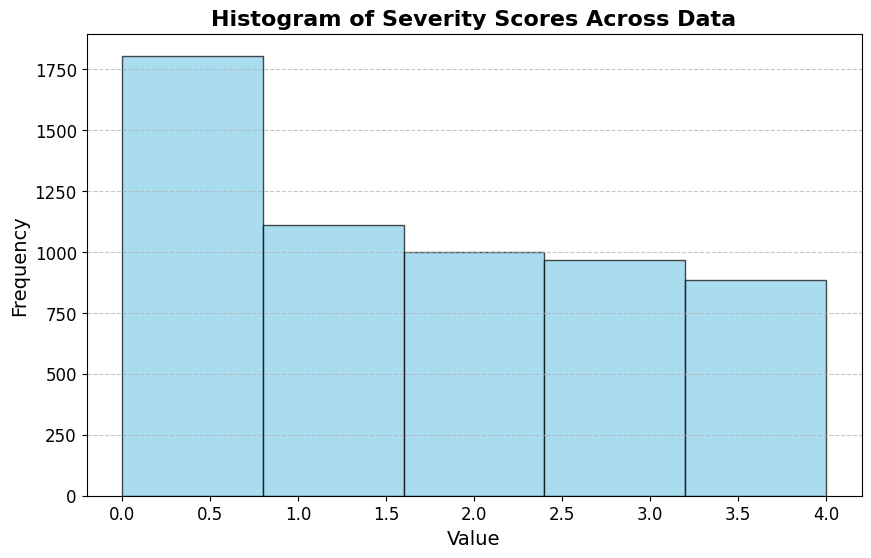

In [ ]:
# Create a histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(y_final, bins=5, edgecolor='black', color='skyblue', alpha=0.7)

# Add titles and labels
plt.title('Histogram of Severity Scores Across Data', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
np.save('x_BALANCED.npy',x_final)
np.save('y_BALANCED.npy',y_final)

# Analysis

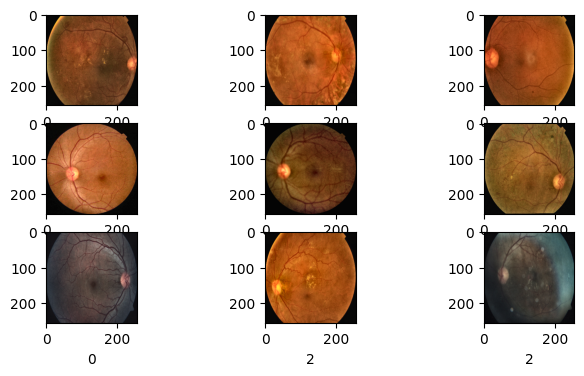

In [ ]:
plt.figure(figsize=(8,4))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_data_clahe[i])

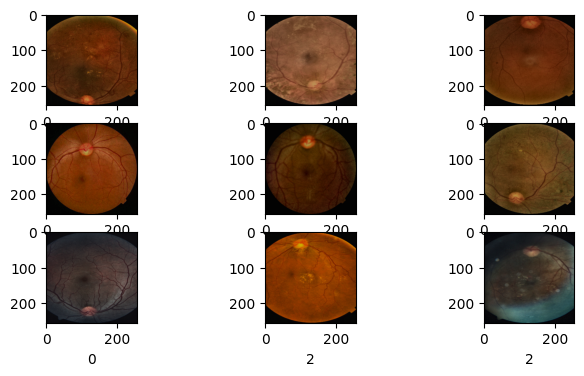

In [ ]:
plt.figure(figsize=(8,4))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_augment1[i])

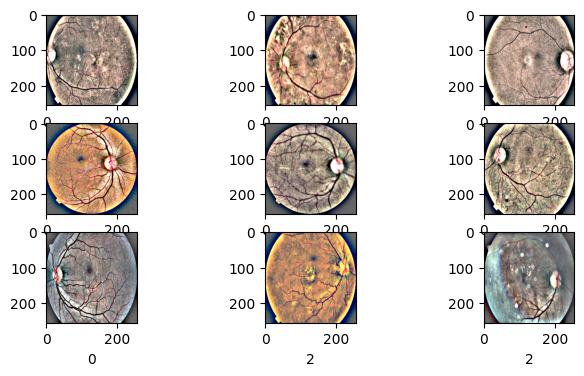

In [ ]:
plt.figure(figsize=(8,4))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_augment2[i])

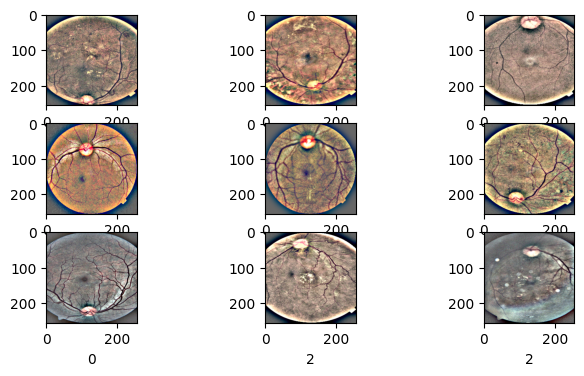

In [ ]:
plt.figure(figsize=(8,4))


for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xlabel(y_data[i])
  plt.imshow(x_augment3[i])